###  MO436C -- Introduction to Self-Supervised (Representation) Learning (SSRL)

Yan Prada Moro and Giovanne Mariano

Campinas, November 22, 2025.

## Masked Autoencoders (MAE) Hands On

In this hands on lecture, we will study a full SSRL pipeline, and thus learn to use self-supervision as a pretraining of a supervised downstream task. The self-supervision pretext task will be the masked image reconstruction.

<img src="https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png" width="600">

We'll use the Masked Autoencoder (MAE) method, which implements this reconstruction task efficiently using an asymmetric encoder-decoder architecture. The encoder operates only on the visible subset of patches (without mask tokens), while a lightweight decoder reconstructs the full image from the latent representation and mask tokens.

Moreover, MAE is typically implemented with Vision Transformers (ViT), leveraging their ability to process variable-length sequences of patches, which is essential for processing only the unmasked portions of the image during encoding.

### Summary <a class="anchor" id="topo"></a>

* [Part 1: Project setup](#part_01).
* [Part 2: Implementing Masked Autoencoders Model](#part_02).
* [Part 3: Implementing Vision Classifier](#part_03).
* [Part 4: Building a MAE training module](#part_04).
* [Part 5: Building a downstream task training module](#part_05).
* [Part 6: Constructing STL10 dataloaders](#part_06).
* [Part 7: Self-supervised pretraining with MAE](#part_07)
* [Part 8: Visualizing some reconstructed images](#part_08).
* [Part 9: Fine-tuning the downstream task (image classification)](#part_09).
* [Part 10: Evaluating the downstream task (image classification)](#part_10).
* [Part 11: Suggestion of exercises on this pipeline](#part_11).

### Part 1: Project setup <a class="anchor" id="part_01"></a>

Here we load the main libraries that will be used throughout this notebook. We also set some configuration parameters for torch reproducibility and filter warnings. 

Finally, we download the pretrained weights that will be used in the downstream task.


In [44]:
import math
import warnings
from typing import Any, Dict, Optional, Tuple
import numpy as np
from pathlib import Path
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from lightly.models import utils
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM
from timm.models.vision_transformer import VisionTransformer
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Subset, random_split
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from torchvision.datasets import STL10
import matplotlib.pyplot as plt

In [ ]:
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "data"
BEST_PRETRAIN_MODEL_PATH = ROOT_DIR / "assets" / "pretrain_weights" / "best_pretrain.pt"
BEST_CLASSIF_MODEL_PATH = ROOT_DIR / "assets" / "weights" / "mae_100_400.pt"

pl.seed_everything(seed=73, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_float32_matmul_precision("medium")

warnings.filterwarnings(
    "ignore",
    "Precision bf16-mixed is not supported by the model summary",
)

warnings.filterwarnings(
    "ignore",
    "Please use the new API settings to control TF32 behavior",
)

Seed set to 73


In [46]:
cfg = {
    "model": {
        "general": {
            "image_size": 96,
            "patch_size": 8,
            "in_chans": 3,
        },
        "encoder": {
            "embed_dim": 144,
            "depth": 4,
            "num_heads": 6,
        },
        "decoder": {
            "decoder_embed_dim": 192,
            "decoder_depth": 2,
            "decoder_num_heads": 6,
        },
        "head": {
            "embed_dim": 144,
            "pool": "cls",
        },
    },
    "pretrain": {
        "mask_ratio_start": 0.75,
        "mask_ratio_end": 0.75,
        "mask_ramp_epochs": 5,
        "total_epochs": 800,
        "warmup_epochs": 20,
        "batch_size": 2000,
        "base_learning_rate": 1.5e-4,
        "weight_decay": 0.05,
        "data_fraction": 1.00,
        "val_split": 0.06,
        "num_workers": 4,
    },
    "train": {
        "samples_per_class": 400,
        "total_epochs": 100,
        "warmup_epochs": 10,
        "batch_size": 2000,
        "learning_rate": 1e-4,
        "weight_decay": 0.05,
        "freeze_encoder": False,
        "num_workers": 4,
    },
    "test": {
        "batch_size": 2000,
        "num_workers": 4,
    },
    "logging": {
        "output_dir_base": "outputs",
        "model_path": "vit-mae.pt",
    },
}

In [ ]:
# Download pretrained weights
if BEST_CLASSIF_MODEL_PATH.exists() is False:
    !bash download_weights.sh

--2025-11-22 09:53:53--  https://github.com/giolucasd/ssrl-vit-mae-jepa/releases/download/v1.0/mae_weights_v1.zip
Resolving github.com (github.com)... 4.228.31.150
Connecting to github.com (github.com)|4.228.31.150|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/1089068822/738ce888-bc6e-4e9f-ab9d-6335fad9d10c?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-22T13%3A27%3A06Z&rscd=attachment%3B+filename%3Dmae_weights_v1.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-22T12%3A27%3A02Z&ske=2025-11-22T13%3A27%3A06Z&sks=b&skv=2018-11-09&sig=tMyy6WR1dtDX942r2bSC%2BrmKHbDcSvBvKG9SMXLJNVk%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MzgxOTUyOSwibmJmIjoxNzYzODE1OTI5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJ

### Part 2: Implementing Masked Autoencoders Model<a class="anchor" id="part_02"></a>
In this part, we will implement the Masked Autoencoder (MAE) model using PyTorch. The MAE consists of an encoder and a decoder, where the encoder processes only the visible patches of the input image, and the decoder reconstructs the full image from the encoded representation and mask tokens.

In [48]:
class MaskedAutoencoder(nn.Module):
    """Masked Autoencoder (MAE) with ViT backbone."""

    def __init__(
        self,
        general_cfg: Dict[str, Any],
        encoder_cfg: Dict[str, Any],
        decoder_cfg: Dict[str, Any],
    ):
        super().__init__()

        self.mask_ratio = general_cfg.get("mask_ratio", 0.75)
        self.image_size = general_cfg.get("image_size", 96)
        self.patch_size = general_cfg.get("patch_size", 6)
        self.in_chans = general_cfg.get("in_chans", 3)

        vit = VisionTransformer(
            img_size=self.image_size,
            patch_size=self.patch_size,
            in_chans=self.in_chans,
            embed_dim=encoder_cfg.get("embed_dim", 384),
            depth=encoder_cfg.get("depth", 12),
            num_heads=encoder_cfg.get("num_heads", 6),
            num_classes=0,
        )

        self.encoder = MaskedVisionTransformerTIMM(vit=vit)
        self.sequence_length = getattr(
            self.encoder,
            "sequence_length",
            vit.patch_embed.num_patches + 1,
        )

        self.decoder = MAEDecoderTIMM(
            num_patches=vit.patch_embed.num_patches,
            patch_size=self.patch_size,
            embed_dim=encoder_cfg.get("embed_dim", 384),
            decoder_embed_dim=decoder_cfg.get("decoder_embed_dim", 512),
            decoder_depth=decoder_cfg.get("decoder_depth", 4),
            decoder_num_heads=decoder_cfg.get("decoder_num_heads", 6),
        )

    def forward_encoder(self, images: torch.Tensor, idx_keep=None):
        return self.encoder.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)

        x_masked = utils.repeat_token(
            token=self.decoder.mask_token,
            size=(batch_size, self.sequence_length),
        )
        x_masked = utils.set_at_index(
            tokens=x_masked,
            index=idx_keep,
            value=x_decode.type_as(x_masked),
        )

        x_decoded = self.decoder.decode(x_masked)
        x_pred = utils.get_at_index(tokens=x_decoded, index=idx_mask)
        x_pred = self.decoder.predict(x_pred)

        return x_pred

    def forward(self, images: torch.Tensor):
        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )

        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)
        x_pred = self.forward_decoder(
            x_encoded=x_encoded, idx_keep=idx_keep, idx_mask=idx_mask
        )

        patches = utils.patchify(images=images, patch_size=self.patch_size)
        idx_mask_adj = torch.clamp(idx_mask - 1, min=0)
        target = utils.get_at_index(tokens=patches, index=idx_mask_adj)

        return x_pred, target

### Part 3: Implementing Vision Classifier<a class="anchor" id="part_03"></a>
In this part, we will implement a Vision Classifier using PyTorch. The classifier will take the encoded representations from the MAE as input and output class predictions for the downstream task, which in this case is the classification of images with the SLT-10 dataset.

In [49]:
class ViTClassifier(nn.Module):
    """Classifier built on top of a pretrained ViT encoder."""

    def __init__(
        self,
        pretrained_encoder: VisionTransformer,
        num_classes: int = 10,
        head_cfg: Optional[Dict[str, Any]] = None,
    ):
        super().__init__()
        self.encoder = pretrained_encoder
        head_cfg = head_cfg or {}

        embed_dim = head_cfg.get("embed_dim", pretrained_encoder.embed_dim)
        pool_type = head_cfg.get("pool", "cls")  # or "mean"

        self.pool_type = pool_type
        self.head = torch.nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor):
        feats = self.encoder.forward_features(x)
        if isinstance(feats, (tuple, list)):
            feats = feats[0]

        if self.pool_type == "cls":
            pooled = feats[:, 0]
        else:
            pooled = feats.mean(dim=1)

        return self.head(pooled)

### Part 4: Building a MAE training module<a class="anchor" id="part_04"></a>
In this part, we will build a training module for the Masked Autoencoder (MAE) model using PyTorch Lightning. This module will handle the training loop, validation, and optimization of the MAE model.

In [50]:
class MAEPretrainModule(pl.LightningModule):
    """Self-supervised pretraining for Masked Autoencoder."""

    def __init__(
        self,
        model_cfg: Dict[str, Any],
        training_cfg: Dict[str, Any],
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = MaskedAutoencoder(
            general_cfg=model_cfg["general"],
            encoder_cfg=model_cfg["encoder"],
            decoder_cfg=model_cfg["decoder"],
        )

        self.mask_start = training_cfg.get("mask_ratio_start", 0.5)
        self.mask_end = training_cfg.get("mask_ratio_end", 0.85)
        self.ramp_epochs = training_cfg.get("mask_ramp_epochs", 200)

        self.lr = float(training_cfg.get("base_learning_rate", 1.5e-4))
        self.weight_decay = float(training_cfg.get("weight_decay", 0.05))
        self.warmup_epochs = int(training_cfg.get("warmup_epochs", 20))
        self.total_epochs = int(training_cfg.get("total_epochs", 200))
        self.batch_size = int(training_cfg.get("batch_size", 512))
        self.criterion = torch.nn.MSELoss()

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        preds, targets = self(imgs)
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        preds, targets = self(imgs)
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        effective_lr = self.lr * self.batch_size / 256
        optimizer = AdamW(
            self.parameters(),
            lr=effective_lr,
            weight_decay=self.weight_decay,
        )

        def lr_lambda(epoch):
            warmup = (epoch + 1) / max(1, self.warmup_epochs)
            cosine = 0.5 * (1 + math.cos(math.pi * epoch / self.total_epochs))
            return min(warmup, 1.0) * cosine

        scheduler = LambdaLR(optimizer, lr_lambda)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "epoch", "name": "lr"},
        }

    def on_train_epoch_start(self):
        """Update mask ratio linearly over epochs."""
        progress = min(self.current_epoch / max(1, self.ramp_epochs - 1), 1.0)
        new_mask = self.mask_start + progress * (self.mask_end - self.mask_start)
        self.model.mask_ratio = new_mask
        self.log("mask_ratio", new_mask, prog_bar=True)

### Part 5: Building a downstream task training module<a class="anchor" id="part_05"></a>
In this part, we will build a training module for the downstream vision classification task using PyTorch Lightning. This module will handle the training loop, validation, and optimization of the vision classifier model.

In [51]:
class ViTClassifierTrainModule(pl.LightningModule):
    """
    Supervised training for ViTClassifier.

    Supports randomly initialized or pretrained ViT encoder.
    Provides both fine-tuning and linear probing.
    """

    def __init__(
        self,
        pretrained_encoder: Optional[torch.nn.Module] = None,
        model_cfg: Optional[Dict[str, Any]] = None,
        training_cfg: Optional[Dict[str, Any]] = None,
        num_classes: int = 10,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["pretrained_encoder"])

        self.model_cfg = model_cfg or {}
        self.training_cfg = training_cfg or {}

        self.learning_rate = float(training_cfg.get("learning_rate", 3e-4))
        self.weight_decay = float(training_cfg.get("weight_decay", 0.05))
        self.warmup_epochs = int(training_cfg.get("warmup_epochs", 5))
        self.total_epochs = int(training_cfg.get("total_epochs", 100))
        self.freeze_encoder_flag = self.training_cfg.get("freeze_encoder", True)
        self.num_classes = num_classes

        # Build model
        encoder_cfg = self.model_cfg.get("encoder", {})
        encoder = (
            pretrained_encoder
            if pretrained_encoder is not None
            else VisionTransformer(
                img_size=self.model_cfg["general"]["image_size"],
                patch_size=self.model_cfg["general"]["patch_size"],
                in_chans=self.model_cfg["general"]["in_chans"],
                embed_dim=encoder_cfg.get("embed_dim", 384),
                depth=encoder_cfg.get("depth", 12),
                num_heads=encoder_cfg.get("num_heads", 6),
                num_classes=0,
            )
        )

        self.model = ViTClassifier(
            pretrained_encoder=encoder,
            num_classes=self.num_classes,
            head_cfg=self.model_cfg.get("head", {}),
        )

        # Freeze or unfreeze encoder as requested
        if self.freeze_encoder_flag:
            self.freeze_encoder()
        else:
            self.unfreeze_encoder()

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = F.cross_entropy(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = F.cross_entropy(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = F.cross_entropy(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

        def lr_lambda(epoch):
            warmup = (epoch + 1) / max(1, self.warmup_epochs)
            cosine = 0.5 * (1 + math.cos(math.pi * epoch / self.total_epochs))
            return min(warmup, 1.0) * cosine

        scheduler = LambdaLR(optimizer, lr_lambda)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_loss",
            },
        }

    def freeze_encoder(self):
        for name, param in self.model.named_parameters():
            if "head" not in name:
                param.requires_grad = False
        print("🧊 Encoder frozen (only classifier head is trainable).")

    def unfreeze_encoder(self):
        for param in self.model.parameters():
            param.requires_grad = True
        print("🔥 Encoder unfrozen (all parameters trainable).")

    def unfreeze_last_layers(self, n_layers: int):
        """
        Unfreezes only the last `n_layers` Transformer blocks of the ViT encoder.
        All earlier layers remain frozen.
        """
        encoder = self.model.encoder  # timm VisionTransformer
        blocks = encoder.blocks  # list of Transformer blocks
        total = len(blocks)

        if n_layers < 0 or n_layers > total:
            raise ValueError(f"n_layers must be between 0 and {total}, got {n_layers}")

        print(f"🔓 Unfreezing last {n_layers} of {total} encoder layers...")

        # 1) Freeze ALL parameters first
        for param in encoder.parameters():
            param.requires_grad = False

        # 2) Unfreeze the last N Transformer blocks
        for block in blocks[total - n_layers :]:
            for param in block.parameters():
                param.requires_grad = True

        # 3) Also unfreeze the final LN (norm) layer
        if hasattr(encoder, "norm"):
            for param in encoder.norm.parameters():
                param.requires_grad = True

        # 4) Head (classifier) is always trainable
        for param in self.model.head.parameters():
            param.requires_grad = True

        print("🔥 Selective unfreezing complete.")

### Part 6: Constructing STL10 dataloaders<a class="anchor" id="part_06"></a>
In this part, we will construct the dataloaders for both the self-supervised pretraining task (MAE) and the downstream supervised task (vision classification). We will use the STL-10 dataset for both tasks, applying appropriate transformations for each.

In [52]:

def _build_transform(train: bool = True) -> transforms.Compose:
    """Standard STL-10 augmentations."""
    if train:
        return transforms.Compose(
            [
                transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
    else:
        return transforms.Compose(
            [
                transforms.Resize(96),
                transforms.CenterCrop(96),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )


def _subset_dataset(dataset, fraction: float) -> Subset | STL10:
    """Optionally take a fraction of a dataset."""
    if fraction < 1.0:
        n = int(len(dataset) * fraction)
        return Subset(dataset, range(n))
    return dataset


def get_pretrain_dataloaders(cfg: dict) -> tuple[DataLoader, DataLoader]:
    """
    Builds train/val dataloaders for self-supervised pretraining (unlabeled split).

    Args:
        cfg (dict): configuration dictionary with keys:
            - batch_size (int)
            - val_split (float)
            - data_fraction (float)
            - seed (int)
            - num_workers (int)
    """
    pre_cfg = cfg["pretrain"]
    seed = cfg.get("seed", 73)

    full_dataset = STL10(
        DATA_DIR,
        split="unlabeled",
        transform=_build_transform(train=True),
        download=True,
    )

    # Optionally subsample dataset
    full_dataset = _subset_dataset(full_dataset, pre_cfg.get("data_fraction", 1.0))

    # Split into train/val subsets
    n_total = len(full_dataset)
    val_split = pre_cfg.get("val_split", 0.1)
    n_val = int(n_total * val_split)
    n_train = n_total - n_val

    train_subset, val_subset = random_split(
        full_dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(seed),
    )
    val_subset.dataset.transform = _build_transform(train=False)

    batch_size = pre_cfg.get("batch_size", 512)
    num_workers = pre_cfg.get("num_workers", 4)

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    print(
        f"📦 Unlabeled pretrain split: {n_train} train, {n_val} val "
        f"({val_split * 100:.1f}% validation)"
    )

    return train_loader, val_loader


def get_train_dataloaders(cfg: dict) -> tuple[DataLoader, DataLoader]:
    """
    Builds train/val dataloaders for fine-tuning on labeled STL-10 split.
    The training set is sampled with `samples_per_class`, and the remaining
    labeled data becomes the validation set.

    Args:
        cfg (dict): configuration dictionary with keys:
            - batch_size (int)
            - samples_per_class (int)
            - seed (int)
            - num_workers (int)
    """
    train_cfg = cfg["train"]
    seed = cfg.get("seed", 73)

    full_dataset = STL10(DATA_DIR, split="train", transform=_build_transform(True))
    labels = np.array(full_dataset.labels)

    samples_per_class = train_cfg.get("samples_per_class", 400)
    train_indices, val_indices = [], []

    for c in np.unique(labels):
        cls_idx = np.where(labels == c)[0]
        np.random.default_rng(seed).shuffle(cls_idx)
        train_indices.extend(cls_idx[:samples_per_class])
        val_indices.extend(cls_idx[samples_per_class:])

    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    val_dataset.dataset.transform = _build_transform(train=False)

    print(
        f"⚙️ Using {samples_per_class} samples/class → {len(train_indices)} train, "
        f"{len(val_indices)} val"
    )

    batch_size = train_cfg.get("batch_size", 256)
    num_workers = train_cfg.get("num_workers", 4)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, val_loader


def get_test_dataloader(cfg: dict) -> DataLoader:
    """Returns only the STL-10 test split for final evaluation."""
    test_cfg = cfg.get("test", {})
    batch_size = test_cfg.get("batch_size", 256)
    num_workers = test_cfg.get("num_workers", 4)

    test_dataset = STL10(DATA_DIR, split="test", transform=_build_transform(False))

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    print(f"🧪 Loaded STL-10 test split: {len(test_dataset)} samples")

    return test_loader


### Part 7: Self-supervised pretraining with MAE<a class="anchor" id="part_07"></a>
In this part, we will perform self-supervised pretraining of the Masked Autoencoder (MAE) model using the STL-10 dataset. We will train the MAE to reconstruct masked patches of images, allowing it to learn useful representations from the data.

In [ ]:
has_weights = BEST_PRETRAIN_MODEL_PATH.is_file()

if has_weights:
    # Load pretrained weights
    print(f"🔄 Loading pretrained weights from: {BEST_PRETRAIN_MODEL_PATH}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(BEST_PRETRAIN_MODEL_PATH, map_location=device)

    pretrain_model = MaskedAutoencoder(
        general_cfg=cfg["model"]["general"],
        encoder_cfg=cfg["model"]["encoder"],
        decoder_cfg=cfg["model"]["decoder"],
    )
    pretrain_model.load_state_dict(checkpoint, strict=False)
    pretrain_model.to(device)
    pretrain_model.eval()
    print("✅ Pretrained weights loaded successfully.")
else:
    pre_cfg = cfg["pretrain"]
    model_cfg = cfg["model"]
    log_cfg = cfg["logging"]

    # ------------------------------
    # Output dirs
    # ------------------------------
    output_dir = Path(log_cfg["output_dir_base"]) / "pretrain"
    ckpt_dir = output_dir / "checkpoints"
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    # ------------------------------
    # Data
    # ------------------------------
    train_loader, val_loader = get_pretrain_dataloaders(cfg)

    # ------------------------------
    # Model setup
    # ------------------------------
    module = MAEPretrainModule(
        model_cfg=model_cfg,
        training_cfg=pre_cfg,
    )

    # ------------------------------
    # Logging + Checkpoints
    # ------------------------------
    tb_logger = TensorBoardLogger(save_dir=str(output_dir / "logs"), name="tb")

    ckpt_best = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        save_last=False,
        verbose=True,
    )
    ckpt_last = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="last",
        save_top_k=1,
        every_n_epochs=1,
        verbose=True,
    )
    ckpt_periodic = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="epoch-{epoch:03d}",
        save_top_k=-1,  # all checkpoints
        every_n_epochs=25,  # save every 25 epochs
        save_weights_only=True,
        save_last=False,
        verbose=False,
    )

    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    # ------------------------------
    # Trainer
    # ------------------------------
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=pre_cfg["total_epochs"],
        logger=tb_logger,
        callbacks=[ckpt_best, ckpt_last, ckpt_periodic, lr_monitor],
        log_every_n_steps=2,
        precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
        gradient_clip_val=1.0,
        gradient_clip_algorithm="norm",
    )

    trainer.fit(module, train_loader, val_loader, ckpt_path=args.resume_from)

    # ------------------------------
    # Save model + metadata
    # ------------------------------
    model_path = output_dir / log_cfg["model_path"]
    torch.save(module.model.state_dict(), model_path)

    print("\n✅ Pretraining complete")
    print(f"📦 Model weights saved to: {model_path}")
    print(f"🏁 Best checkpoint: {ckpt_best.BEST_PRETRAIN_MODEL_PATH}")
    print(f"📈 Logs available at: {tb_logger.log_dir}")


🔄 Loading pretrained weights from: /home/yan/doutorado/disciplinas/mo436/ssrl-vit-mae-jepa/assets/weights/mae_100_400.pt


RuntimeError: Error(s) in loading state_dict for MaskedAutoencoder:
	Missing key(s) in state_dict: "encoder.mask_token", "decoder.mask_token", "decoder.decoder_pos_embed", "decoder.decoder_embed.weight", "decoder.decoder_embed.bias", "decoder.decoder_blocks.0.norm1.weight", "decoder.decoder_blocks.0.norm1.bias", "decoder.decoder_blocks.0.attn.qkv.weight", "decoder.decoder_blocks.0.attn.qkv.bias", "decoder.decoder_blocks.0.attn.proj.weight", "decoder.decoder_blocks.0.attn.proj.bias", "decoder.decoder_blocks.0.norm2.weight", "decoder.decoder_blocks.0.norm2.bias", "decoder.decoder_blocks.0.mlp.fc1.weight", "decoder.decoder_blocks.0.mlp.fc1.bias", "decoder.decoder_blocks.0.mlp.fc2.weight", "decoder.decoder_blocks.0.mlp.fc2.bias", "decoder.decoder_blocks.1.norm1.weight", "decoder.decoder_blocks.1.norm1.bias", "decoder.decoder_blocks.1.attn.qkv.weight", "decoder.decoder_blocks.1.attn.qkv.bias", "decoder.decoder_blocks.1.attn.proj.weight", "decoder.decoder_blocks.1.attn.proj.bias", "decoder.decoder_blocks.1.norm2.weight", "decoder.decoder_blocks.1.norm2.bias", "decoder.decoder_blocks.1.mlp.fc1.weight", "decoder.decoder_blocks.1.mlp.fc1.bias", "decoder.decoder_blocks.1.mlp.fc2.weight", "decoder.decoder_blocks.1.mlp.fc2.bias", "decoder.decoder_norm.weight", "decoder.decoder_norm.bias", "decoder.decoder_pred.weight", "decoder.decoder_pred.bias". 
	Unexpected key(s) in state_dict: "head.classification.weight", "head.classification.bias". 

### Part 8: Visualizing some reconstructed images<a class="anchor" id="part_08"></a>
In this part, we will visualize some of the reconstructed images produced by the Masked Autoencoder (MAE) model after self-supervised pretraining. This will help us assess the quality of the reconstructions and the effectiveness of the learned representations.

In [73]:
class MAEReconstructor:
    """Handles MAE model reconstruction and validation."""

    def __init__(
        self, model: MaskedAutoencoder, device: Optional[str] = None, mask_ratio: float = 0.75
    ):
        """
        Initialize the MAE reconstructor.

        Args:
            model_path: Path to the saved model checkpoint
            device: Device to run inference on. If None, auto-detects GPU/CPU
            mask_ratio: Ratio of patches to mask (0.0 to 1.0)
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.mask_ratio = mask_ratio
        self.model = model


    def reconstruct_batch(
        self, images: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Reconstruct a batch of masked images.

        Args:
            images: Input images tensor [B, C, H, W]

        Returns:
            Tuple of (original_images, masked_images, reconstructed_images)
        """
        if self.model is None:
            raise RuntimeError("Model not loaded. Call load_model() first.")

        images = images.to(self.device)

        with torch.no_grad():
            # Get random mask
            batch_size = images.shape[0]
            sequence_length = self.model.sequence_length

            # Create fixed mask indices (same for all batches)
            torch.manual_seed(42)  # Set seed for reproducible mask
            idx_keep, idx_mask = utils.random_token_mask(
                size=(batch_size, sequence_length),
                mask_ratio=self.mask_ratio,
                device=self.device,
            )

            # Forward pass through encoder and decoder
            x_encoded = self.model.forward_encoder(images=images, idx_keep=idx_keep)
            x_pred = self.model.forward_decoder(x_encoded, idx_keep, idx_mask)

            # Create masked images for visualization
            masked_images = self._create_masked_images(images, idx_keep, idx_mask)
            # Reconstruct full images
            reconstructed = self._reconstruct_full_images(
                images, x_pred, idx_keep, idx_mask
            )

        return images, masked_images, reconstructed

    def _create_masked_images(
        self, images: torch.Tensor, idx_keep: torch.Tensor, idx_mask: torch.Tensor
    ) -> torch.Tensor:
        """Create masked versions of images for visualization."""
        patches = utils.patchify(images=images, patch_size=self.model.patch_size)
        # Set masked patches to zero (or gray)
        masked_patches = patches.clone()
        idx_mask_adj = torch.clamp(idx_mask - 1, min=0)

        # Create mask tensor
        mask = torch.zeros_like(patches)
        for i in range(patches.shape[0]):
            mask[i, idx_mask_adj[i]] = 1

        # Apply mask (set to gray value)
        masked_patches = masked_patches * (1 - mask) + mask * 0.5
        # Reconstruct images from patches
        return utils.unpatchify(
            patches=masked_patches,
            patch_size=self.model.patch_size,
        )

    def __remove_cls_token(self, idx: torch.Tensor, B: int) -> torch.Tensor:
        mask_not_cls_keep = idx != 0
        idx_no_cls = idx[mask_not_cls_keep].reshape(B, -1)
        idx_no_cls = idx_no_cls - 1  # Adjust indices
        return idx_no_cls

    def _reconstruct_full_images(
        self,
        original: torch.Tensor,
        predictions: torch.Tensor,
        idx_keep: torch.Tensor,
        idx_mask: torch.Tensor,
    ) -> torch.Tensor:
        """Reconstruct full images by combining original and predicted patches."""

        patches = utils.patchify(images=original, patch_size=self.model.patch_size)
        B, N, D = patches.shape
        full_tokens = torch.zeros_like(patches)
        # The following logic assumes that the CLS token (index 0) is always kept
        # and needs to be removed from the indices before reconstructing the image,
        # as the image does not have a CLS token.

        # Remove CLS token index (0) from idx_keep
        idx_keep_no_cls = self.__remove_cls_token(idx_keep, B)
        # Remove CLS token index (0) from idx_mask if it exists
        idx_mask_no_cls = self.__remove_cls_token(idx_mask, B)

        # Gather the patches that were kept (visible)
        kept_patches = patches.gather(
            1, idx_keep_no_cls.unsqueeze(-1).expand(-1, -1, D)
        )
        # Insert original visible tokens
        full_tokens.scatter_(
            1, idx_keep_no_cls.unsqueeze(-1).expand(-1, -1, D), kept_patches
        )

        # Insert predicted masked tokens
        full_tokens.scatter_(
            1, idx_mask_no_cls.unsqueeze(-1).expand(-1, -1, D), predictions
        )

        # Step 4: unpatchify back into the image
        return utils.unpatchify(full_tokens, self.model.patch_size)

    def validate_reconstruction(
        self,
        dataloader: DataLoader,
        num_samples: int = 8,
        save_path: Optional[str] = None,
    ) -> None:
        """
        Validate model reconstruction on dataset samples.

        Args:
            dataloader: DataLoader for validation dataset
            num_samples: Number of samples to visualize
            save_path: Path to save visualization (optional)
        """
        # Get a batch of data
        data_iter = iter(dataloader)
        batch = next(data_iter)

        if isinstance(batch, (list, tuple)):
            images = batch[0]  # Assume first element is images
        else:
            images = batch

        # Limit to num_samples
        images = images[:num_samples]

        # Reconstruct
        original, masked, reconstructed = self.reconstruct_batch(images)

        # Visualize results
        self._visualize_reconstruction(
            original.cpu(), masked.cpu(), reconstructed.cpu(), save_path
        )

        # Print statistics
        self._print_reconstruction_stats(original.cpu(), reconstructed.cpu())

    def _visualize_reconstruction(
        self,
        original: torch.Tensor,
        masked: torch.Tensor,
        reconstructed: torch.Tensor,
        save_path: Optional[str] = None,
    ) -> None:
        """Visualize original, masked, and reconstructed images."""
        num_samples = original.shape[0]

        fig, axes = plt.subplots(3, num_samples, figsize=(2 * num_samples, 6))
        if num_samples == 1:
            axes = axes.reshape(-1, 1)

        for i in range(num_samples):
            # Original
            axes[0, i].imshow(self._tensor_to_image(original[i]))
            axes[0, i].set_title("Original")
            axes[0, i].axis("off")

            # Masked
            axes[1, i].imshow(self._tensor_to_image(masked[i]))
            axes[1, i].set_title(f"Masked ({self.mask_ratio:.0%})")
            axes[1, i].axis("off")

            # Reconstructed
            axes[2, i].imshow(self._tensor_to_image(reconstructed[i]))
            axes[2, i].set_title("Reconstructed")
            axes[2, i].axis("off")

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            print(f"Visualization saved to {save_path}")

        plt.show()

    def _tensor_to_image(self, tensor: torch.Tensor) -> np.ndarray:
        """Convert tensor to displayable image."""
        # Denormalize based on the provided transformation
        mean = torch.tensor([0.5, 0.5, 0.5])
        std = torch.tensor([0.5, 0.5, 0.5])

        if tensor.shape[0] == 3:  # CHW format
            tensor = tensor * std.view(-1, 1, 1) + mean.view(-1, 1, 1)
            tensor = tensor.permute(1, 2, 0)  # HWC

        tensor = torch.clamp(tensor, 0, 1)
        return tensor.numpy()

    def _print_reconstruction_stats(
        self, original: torch.Tensor, reconstructed: torch.Tensor
    ) -> None:
        """Print reconstruction quality statistics."""
        mse = nn.MSELoss()(original, reconstructed)
        mae = nn.L1Loss()(original, reconstructed)

        print("\nReconstruction Statistics:")
        print(f"MSE Loss: {mse.item():.6f}")
        print(f"MAE Loss: {mae.item():.6f}")
        print(f"PSNR: {-10 * torch.log10(mse).item():.2f} dB")

📦 Unlabeled pretrain split: 94000 train, 6000 val (6.0% validation)


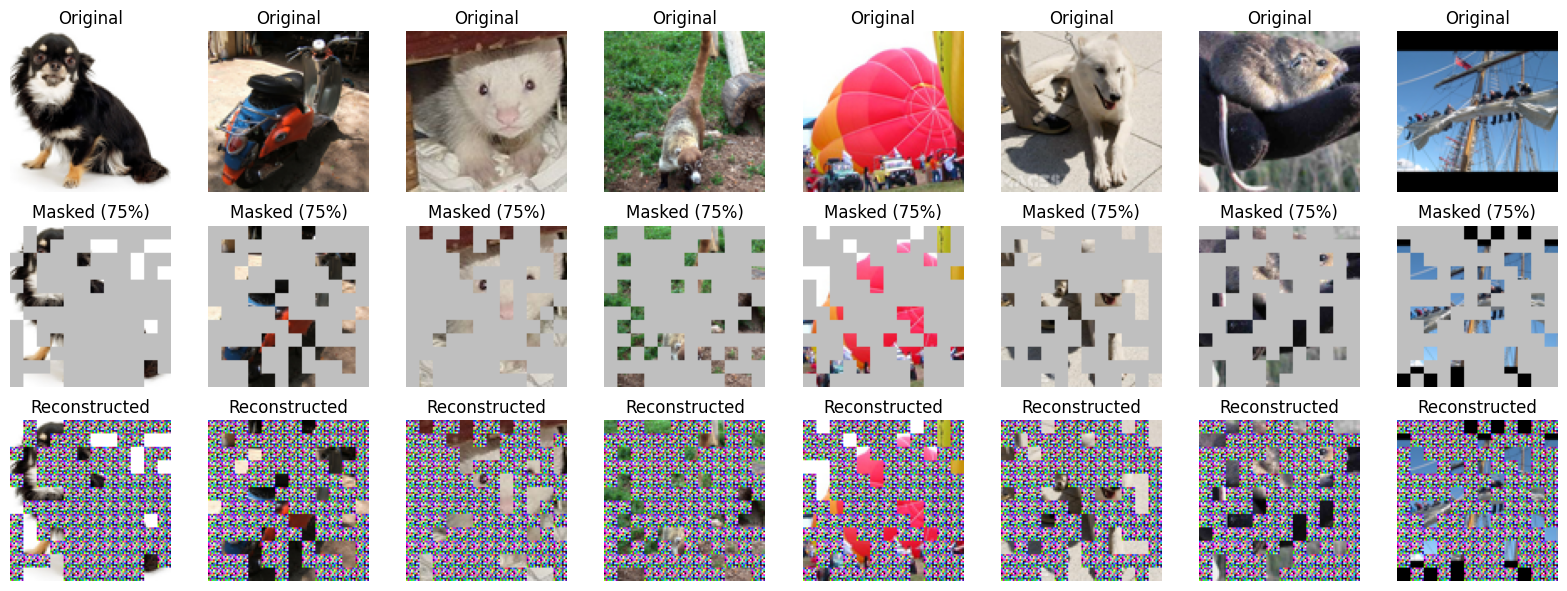


Reconstruction Statistics:
MSE Loss: 0.993358
MAE Loss: 0.698770
PSNR: 0.03 dB


In [74]:
train_loader, val_loader = get_pretrain_dataloaders(cfg)
reconstructor = MAEReconstructor(model=pretrain_model, mask_ratio=cfg["pretrain"]["mask_ratio_end"])
reconstructor.validate_reconstruction(val_loader, num_samples=8)

### Part 9: Fine-tuning the downstream task (image classification) <a class="anchor" id="part_09"></a>
In this part, we will fine-tune the vision classifier model on the downstream image classification task using the STL-10 dataset. We will leverage the representations learned by the MAE during self-supervised pretraining to improve classification performance.